---
# Généralisation et Machine Learning
---

On se propose dans ce TD d'étudier la question de la généralisation du Machine Learning sur quelques exemples: régression et classification.

Le TD est organisé en deux parties:
* une implémentation et analyse de l'exemple de la régression polynomiale vu en cours
* la mise en oeuvre de la validation croisée sur quelques exemples

In [1]:
# Bibliothèques de base à importer
from IPython.core import error
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

## Régression polynomiale et compromis biais/variance



La régression polynomiale consiste à estimer une fonction à valeurs réelles à partir de quelques points. On utilise comme modèle d'une telle fonction une forme additive:

$$y=f(x)+\epsilon$$

où $f$ est une fonction idéale inconnue et $\epsilon$ est un bruit additif gaussien centré d'écart type $\sigma$: $\epsilon \sim \mathcal{N}(0,\sigma)$.


In [2]:
def f(X):
  return np.sqrt(X) * np.sin(X)

# Générateur de données
def samples(f, n_samples = 9, noise = 0.5, x_min = 0, x_max = 10, uniform=True):
  # tri des données pour la visualisation
  if uniform:
    X = np.linspace(x_min, x_max, n_samples)
  else:
    X = np.sort((x_max-x_min) * rng.rand(n_samples) + x_min)
    X[0] = x_min
    X[-1] = x_max

  noise = rng.normal(0, 1, n_samples) * noise
  y = f(X) + noise

  return X,y


### Réaliser un premier régresseur

Le prédicteur peut être estimé par une régression polynomiale aux moindre carrés.

On utilisera les fonctions [`polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) (estimation) et  [`polyval`](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html#numpy.polyval) (prédiction) fournies par `numpy` pour simplifier l'écriture du code.

[ 7.67566672e-04 -3.10538313e-02  3.77109821e-01 -1.59316434e+00
  1.33438570e+00  2.09261643e+00]


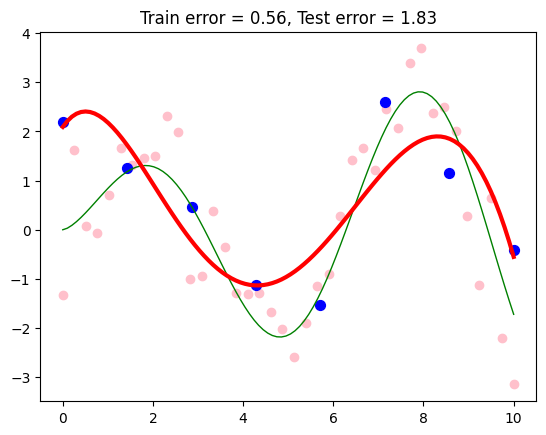

In [3]:
from numpy import polyfit, polyval
# Pour filtrer les messages d'erreur
import warnings
warnings.simplefilter('ignore', np.RankWarning)

n_samples = 8

# Limites de l'intervalle de régression
x_min = 0
x_max = 10

# Niveau de bruit (écart type)
sigma = 0.8

# Données pour visualiser fonctions
X_plot = np.linspace(x_min, x_max, 100)
y_plot = f(X_plot)

# Initialisation aléatoire
seed = datetime.now().microsecond
rng = np.random.RandomState(seed)

# Données d'apprentissage
X_train, y_train = samples(f, n_samples=n_samples, noise = sigma, x_min=x_min, x_max=x_max, uniform=True)

# Données de test (en plus grande quantité que les données d'apprentissage)
X_test, y_test = samples(f, n_samples=5*n_samples, noise = sigma, x_min=x_min, x_max=x_max, uniform=True)

degree = 5

theta = polyfit(X_train, y_train, degree)
print(theta)

y_reg_poly = polyval(theta, X_plot)
y_reg_test = polyval(theta, X_test)
y_reg_train = polyval(theta, X_train)

err_train = ((y_reg_train-y_train)**2).mean()
err_test = ((y_reg_test-y_test)**2).mean()

plt.plot(X_plot, y_plot, color="green", label="Ground Truth", linewidth=1)
plt.plot(X_plot, y_reg_poly, color="red", label="Ground Truth", linewidth=3)
plt.scatter(X_test, y_test, c='pink')
plt.scatter(X_train, y_train,  s=50, marker='o', c='blue')
plt.title("Train error = {:.2f}, Test error = {:.2f}".format(err_train, err_test))

plt.show()

### Impact de la complexité du prédicteur

Une grande erreur de généralisation peut être la conséquence de deux phénomènes distincts:
* Le **sous-apprentissage** ou simplisme, qui est causé par des prédicteurs d'expressivité limitée
* Le **sur-apprentissage** ("overfitting"), qui est causé par l'estimation d'un prédicteur trop souple et incapable d'identifier les régularités dans les données ("par coeur").





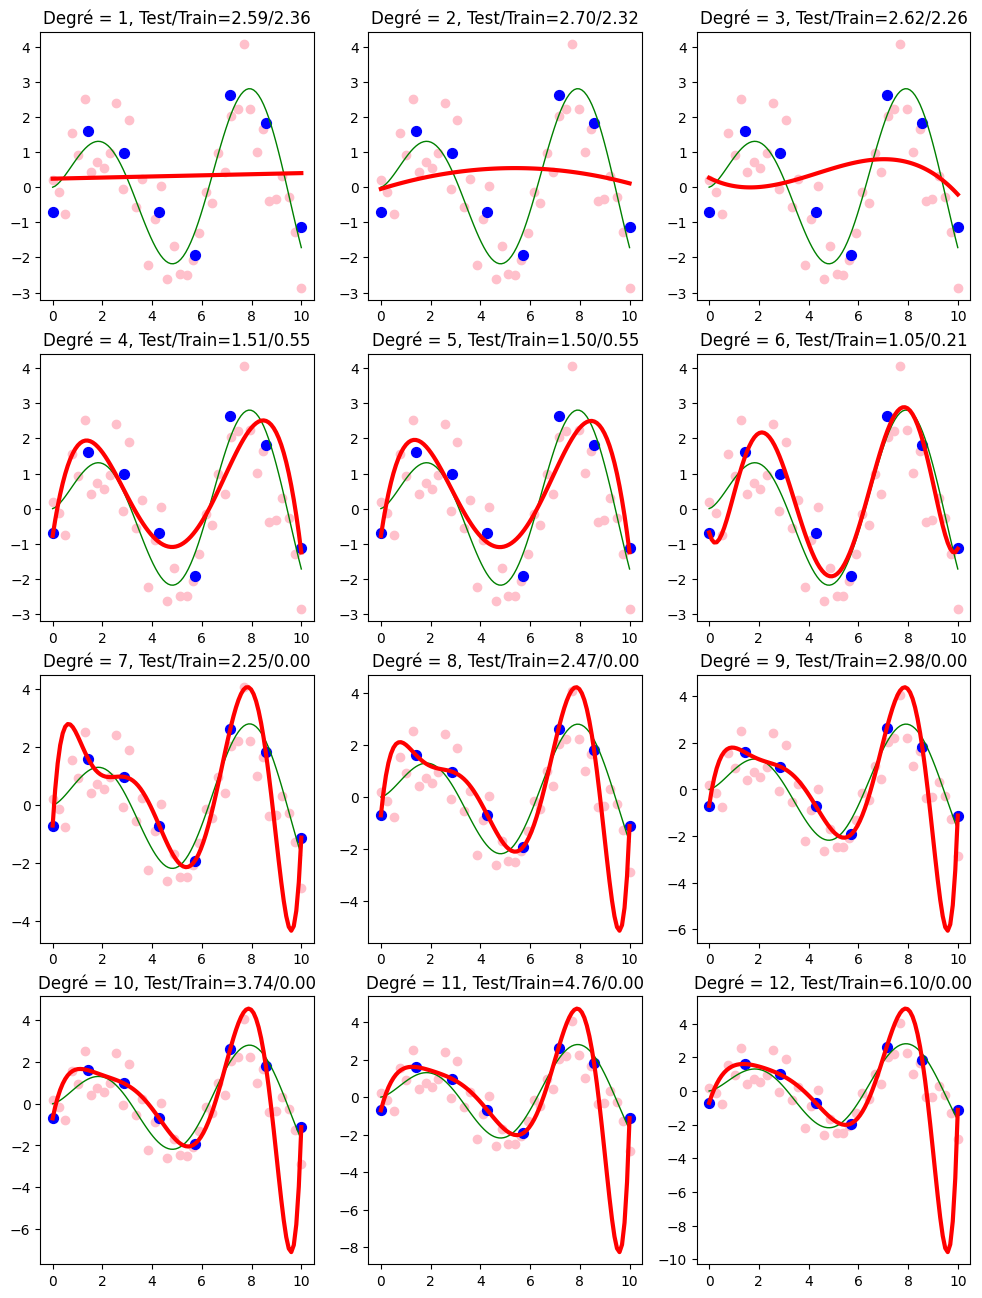

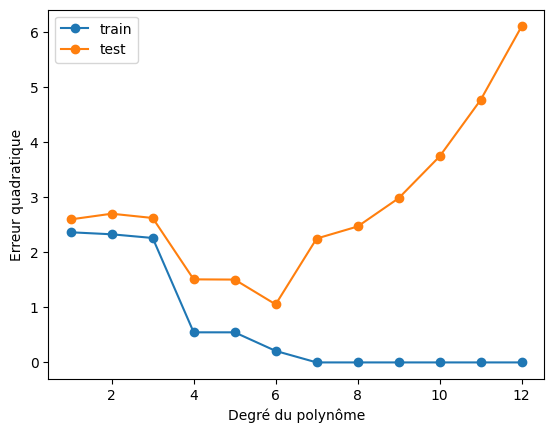

In [6]:
n_samples = 8

# Initialisation aléatoire
seed = datetime.now().microsecond
rng = np.random.RandomState(seed)

sigma = 0.8

# Données d'apprentissage et de test
X_train, y_train = samples(f, n_samples=n_samples, noise = sigma, x_min=x_min, x_max=x_max, uniform=True)
X_test, y_test = samples(f, n_samples=5*n_samples, noise = sigma, x_min=x_min, x_max=x_max, uniform=True)

max_degree = 12

degrees = range(1, max_degree+1)

# Boucle sur les degrés max des polynômes
nc=3
nl=np.ceil(len(degrees)/nc).astype(int)

fig, axs = plt.subplots(nl, nc, figsize=(nc*4, nl*4))

error=[]
for ideg, deg in enumerate(degrees):

  ii = ideg // nc
  jj = ideg % nc


  theta = np.polyfit(X_train, y_train, deg)

  y_reg_poly = np.polyval(theta, X_plot)
  y_reg_test = np.polyval(theta, X_test)
  y_reg_train = np.polyval(theta, X_train)

  err_train = ((y_reg_train-y_train)**2).mean()
  err_test = ((y_reg_test-y_test)**2).mean()

  error.append([err_train, err_test])

  axs[ii,jj].plot(X_plot, y_plot, color="green", label="Ground Truth", linewidth=1)
  axs[ii,jj].plot(X_plot, y_reg_poly, color="red", label="Ground Truth", linewidth=3)
  axs[ii,jj].scatter(X_test, y_test, c='pink')
  axs[ii,jj].scatter(X_train, y_train,  s=50, marker='o', c='blue')
  axs[ii,jj].set_title("Degré = {}, Test/Train={:.2f}/{:.2f}".format(deg,err_test, err_train))

plt.show()

error = np.array(error)

plt.plot(degrees, error[:,0], label='train', marker='o')
plt.plot(degrees, error[:,1], label='test', marker='o')
plt.xlabel("Degré du polynôme")
plt.ylabel("Erreur quadratique")
plt.legend(loc='upper left')
plt.show()


### Visualisation de la variance d'apprentissage

Nous allons dans cette section visualiser l'impact de la variance d'apprentissage sur l'erreur d'apprentissage.

Pour rappel, on peut décomposer l'erreur de généralisation comme la somme de trois termes dans le cas de la régression appliquée à un modèle à bruit additif:

$$
\begin{align}
err^2 &= E[(\hat{f}_D(x) - y)^2] &\\
&= E[\hat{f}_D(x) - f(x)]^2  &\text{(biais)}\\
& \;\;\; + E[E[\hat{f}_D(x)] - \hat{f}_D(x)]^2 &\text{(variance)}\\
& \;\;\; + E[(y-f(x))^2] &\text{(erreur de Bayes)}
\end{align}
$$
où les espérances mathématiques sont prises sur des échantillons de bases d'apprentissage $D$.


Le code ci-dessous illustre la variation des comportements en fonction du degré du polynôme.

In [7]:
from collections import defaultdict
# Le problème de régression
n_samples = 8

sigma = .5
x_min = 0
x_max = 10

# Variables de stockage (dictionnaires)
pred_train = defaultdict(list)
pred_test = defaultdict(list)

train_errors = defaultdict(list)
test_errors = defaultdict(list)

theta_hat = defaultdict(list)

# Nombre de tirages de bases d'apprentissage
n_datasets = 50

# Degrés des polynômes à tester
max_poly_degree = 10  # Maximum model complexity
degrees = range(1, max_poly_degree + 1)

# Boucle sur les bases d'apprentissage
for dataset in range(n_datasets):

    # Ensembles d'apprentissage et test. 5 fois plus d'exemples de test
    X_train, y_train = samples(f, n_samples=n_samples, noise = sigma, x_min=x_min, x_max=x_max)
    X_test, y_test = samples(f, n_samples=5*n_samples, noise = sigma, x_min=x_min, x_max=x_max)

    # Boucle sur les degrés des polynômes
    for degree in degrees:
        # Apprentissage du prédicteur et stockage des paramètres
        theta = np.polyfit(X_train, y_train, degree)
        theta_hat[degree].append(theta)

        # Calcul des prédictions sur ensemble d'apprentissage et stockage
        y_reg_train = np.polyval(theta, X_train)
        pred_train[degree].append(y_reg_train)

        # Calcul des prédictions sur ensemble de test et stockage
        y_reg_test = np.polyval(theta, X_test)
        pred_test[degree].append(y_reg_test)

        # Erreurs d'apprentissage et test
        train_errors[degree].append(np.mean((y_reg_train - y_train)**2))
        test_errors[degree].append(np.mean((y_reg_test - y_test)**2))


<ipython-input-8-a2daa98b2c88>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired')


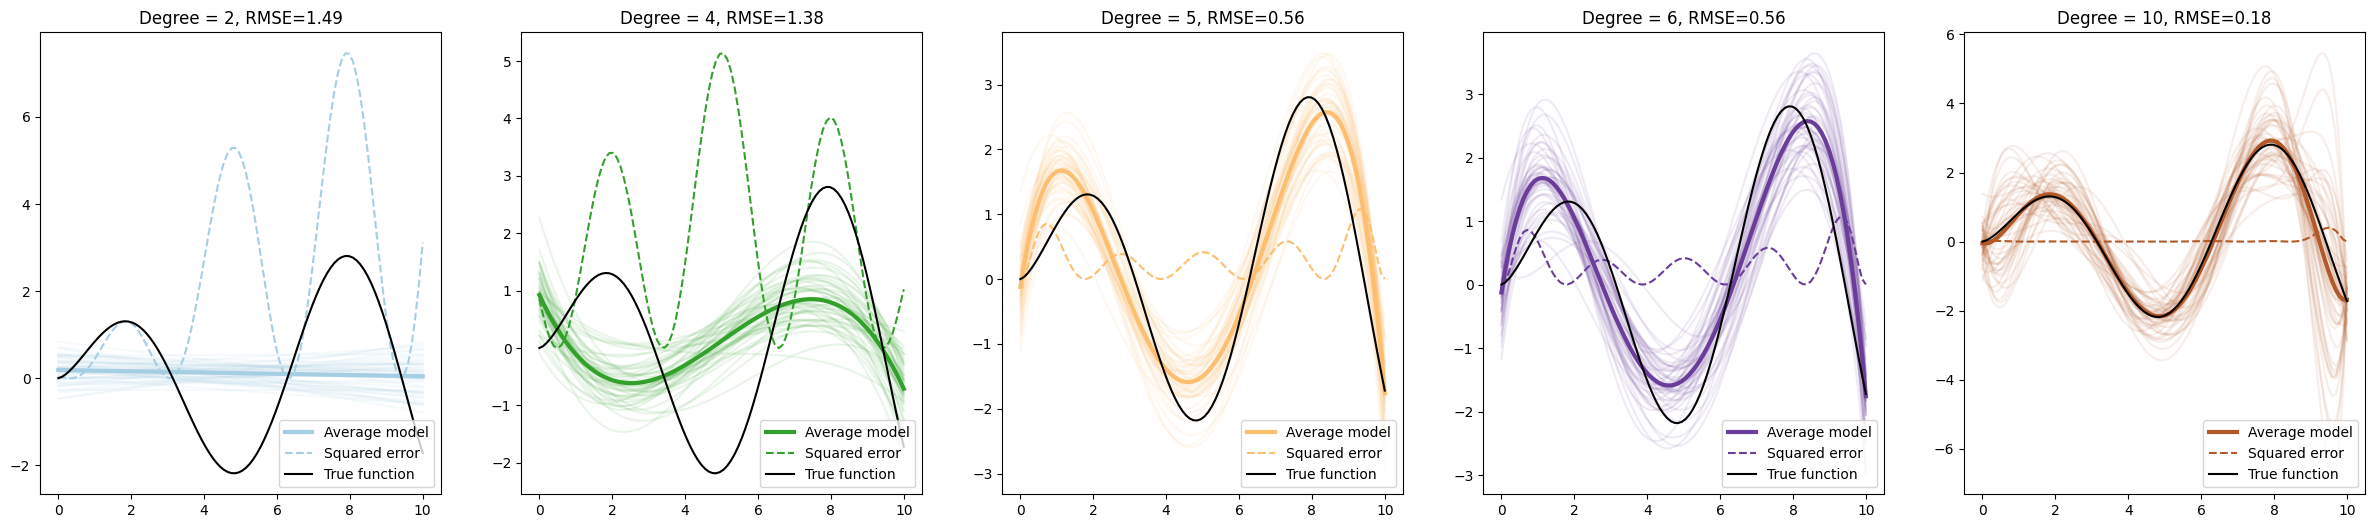

In [8]:
############## Visualisation ###################

# Sélection de degrés
idegrees = [1,3,4,5,9]

# Colormaps pour la visualisation
cmap = plt.cm.get_cmap('Paired')
colors = [cmap(i) for i in np.linspace(0, 1, len(idegrees))]

# Données pour visualiser fonctions
X_plot = np.linspace(x_min, x_max, 100)
y_plot = f(X_plot)

fig, axs = plt.subplots(1, len(idegrees), figsize=(len(idegrees)*6, 6))

for ii, idegree in enumerate(idegrees):
  plt.sca(axs[ii])

  # Calcul et visu de la courbe du prédicteur pour chaque tirage
  sim_fit = []
  for theta in theta_hat[idegree]:
    y_reg_plot = np.polyval(theta, X_plot)
    sim_fit.append(y_reg_plot)
    plt.plot(X_plot, y_reg_plot, color=colors[ii], alpha=.1)

  # Estimation du prédicteur moyen
  average_fit = np.array(sim_fit).mean(0)

  # Calcul du biais
  squared_error = (average_fit - y_plot)**2
  rms = np.sqrt(squared_error.mean())

  # Visu des courbes
  plt.plot(X_plot, average_fit, color=colors[ii], linewidth=3, label='Average model')
  plt.plot(X_plot, squared_error, '--', color=colors[ii], label='Squared error')
  plt.plot(X_plot, y_plot, color='black', label='True function')

  plt.title(f"Degree = {degrees[idegree]}, RMSE={np.round(rms, 2)}")
  plt.legend(loc='lower right')


### Estimation du compromis biais/variance

On aimerait générer un graphique comme celui ci-dessous, qui mette en relation les biais et variance d'estimation pour différents degrés des polyômes prédicteurs:

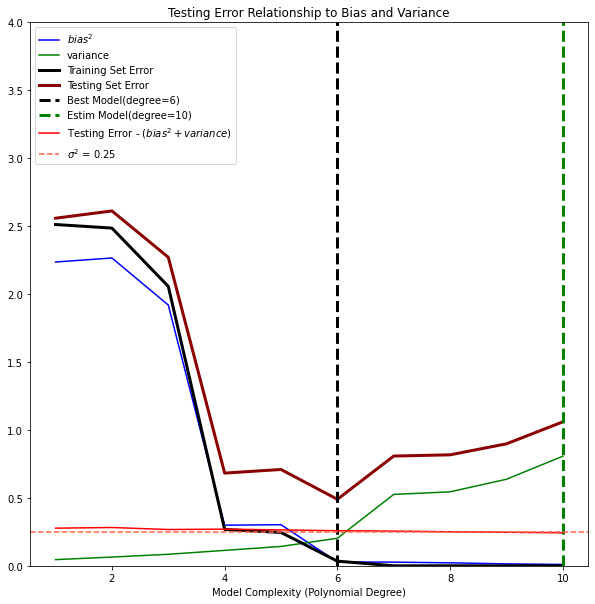

Il fallait produire pour chaque degré, à partir de plusieurs tirages des données d'apprentissage, les quantités suivantes:
- L'erreur d'apprentissage moyenne
- L'erreur de test
- L'écart quadratique moyen entre prédiction et fonction idéale (le **biais**)
- L'écart quadratique moyen entre prédiction et prédicteur moyen (la **variance** d'apprentissage)

On pourra vérifier que l'on retrouve bien le bruit du modèle (l'écart type $\sigma$ du bruit additif $\epsilon$) comme différence entre l'erreur de test et la somme du biais et de la variance:

$$err_{RMS}^2 = \sigma^2 + biais^2 + variance$$


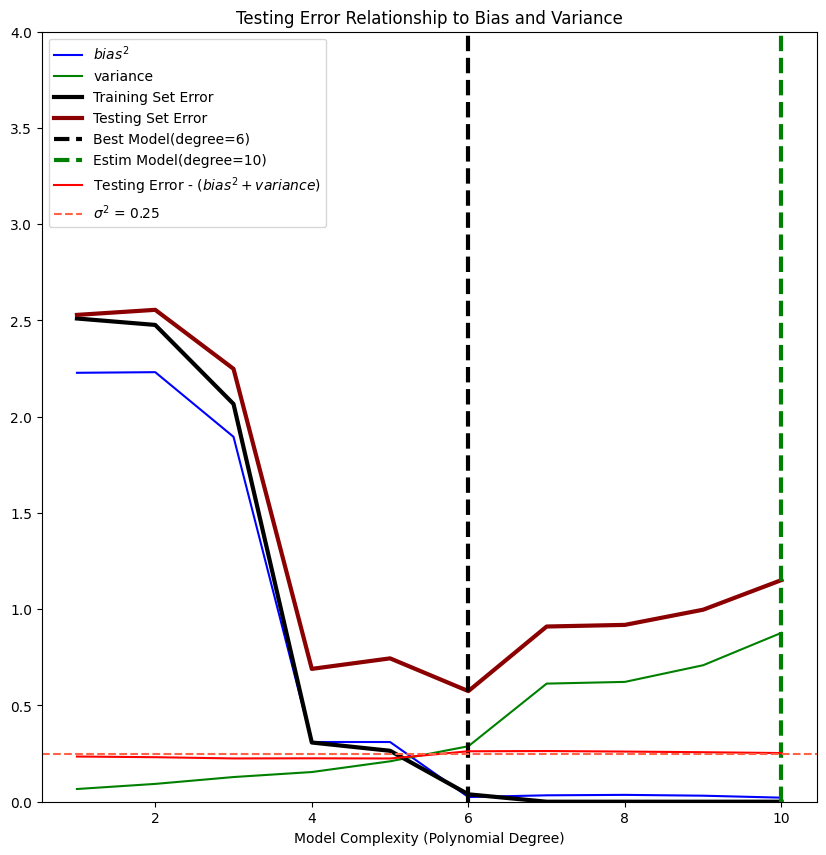

In [9]:
poly_train_error = []
poly_test_error = []
bias_squared = []
variance = []

best_model_degree = -1
best_estim_degree = -1

def calculate_estimator_bias_squared(y_clean_test, pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (E[g(x)] - f(x))^2, averaged across all trials
    return np.mean((average_model_prediction - y_clean_test) ** 2)

def calculate_estimator_variance(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (g(x) - E[g(x)])^2, averaged across all trials
    return np.mean((pred_test - average_model_prediction) ** 2)


_, y_test = samples(f, n_samples=5*n_samples, noise = sigma, x_min=x_min, x_max=x_max)
y_clean_test = f(X_test)

for degree in degrees:
    poly_train_error.append(np.mean(train_errors[degree]))
    poly_test_error.append(np.mean(test_errors[degree]))
    bias_squared.append(calculate_estimator_bias_squared(y_clean_test, pred_test[degree]))
    variance.append(calculate_estimator_variance(pred_test[degree]))

best_model_degree = degrees[np.argmin(poly_test_error)]
best_estim_degree = degrees[np.argmin(poly_train_error)]


# Visualizations
MARKER_SIZE = 100
DATA_COLOR = 'black'
ERROR_COLOR = 'darkred'

## Plot Bias^2 + variance
fig, axs = plt.subplots(figsize=(10, 10))

plt.plot(degrees, bias_squared, color='blue', label='$bias^2$')
plt.plot(degrees, variance, color='green', label='variance')
plt.plot(degrees, poly_train_error, label='Training Set Error', linewidth=3, color=DATA_COLOR)
#plt.plot(degrees, np.array(bias_squared) + np.array(variance),  linestyle='-.', color='gray', label='$bias^2 + variance$')
plt.plot(degrees, poly_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})', linewidth=3)
plt.axvline(best_estim_degree, linestyle='--', color='green', label=f'Estim Model(degree={best_estim_degree})', linewidth=3)
plt.plot(degrees, np.array(poly_test_error) - (np.array(bias_squared) + np.array(variance)), color='red', label='Testing Error - ($bias^2 + variance$)')
plt.axhline(sigma **2, color='tomato', linestyle='--', label=f'$\sigma^2$ = {round(sigma**2, 3)}')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylim([0, 4.0]);
plt.legend()
plt.title('Testing Error Relationship to Bias and Variance')

plt.show()


## Validation croisée

La technique de validation croisée permet d'estimer l'erreur de généralisation lorsque l'on dispose d'un jeu limité de données. Son principe est de simuler des ensembles de tests fictifs (appelés ensemble de **validation**) à partir des données d'apprentissage, et d'estimer les performances sur ces données de validation.



In [10]:
## Elements de codes utiles pour visualisation (à exécuter)
import warnings
warnings.simplefilter('ignore', np.RankWarning)
warnings.simplefilter('ignore', RuntimeWarning)

# Visualisation des données en deux dimension
def show_data_2D(X,Y,ax=None, s=30):
    np.unique(Y)
    if ax is None:
        ax = plt.gca()
    for id in np.unique(Y):
        idpositive=np.nonzero(Y == id)[0]
        ax.scatter(X[idpositive,0], X[idpositive,1], s=s)

# Visualisation des fonctions séparatrices en deux dimensions
def plot_decision_function(decision_function, ax=None, margin=False):
    """Plot the decision function """
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    score = decision_function(xy)

    if score.ndim == 1 :
      P = score.reshape(X.shape)
    else:
      P = (score[:,1]-score[:,0]).reshape(X.shape)

    Z = 1*(P>0) -1*(P<=0)
    ax.contourf(X, Y, Z,  alpha=0.2)

    # plot decision boundary and margins
    if margin:
      ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    else:
      ax.contour(X, Y, P, colors='k',
                levels=[0], alpha=0.5,
                linestyles=['-'])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


### Influence des hyper-paramètres

La validation croisée est utilisée ici pour estimer les **hypermaramètres** de certaines familles de prédicteurs: ce sont des paramètres de dimension réduite, mais que l'on ne peut estimer itérativement. Ils ont en général un impact global et structurel sur le prédicteur.

Des hyper-paramètres classiques sont le nombre de voisins pour le kNN, la profondeur maximale pour les arbres de décision, les paramètres de régularisation.

Le problème de classification traité est généré par le code ci-dessous. Il est paramétrable par un facteur de bruit qui permet de produire différents niveaux de confusion.

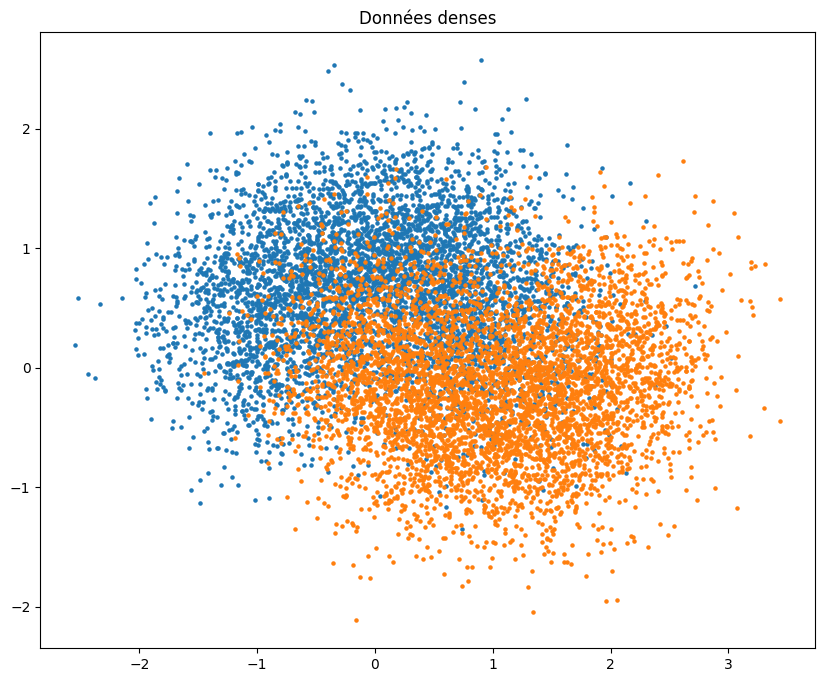

In [11]:
from sklearn.datasets import make_moons

# Paramètre réglant la distribution spatiale des données
noise = 0.5
random_state = datetime.now().microsecond

# Données de test
X_test, y_test = make_moons(noise=noise, random_state=random_state, n_samples=10000)

fig, ax = plt.subplots(figsize=(10, 8))
show_data_2D(X_test,y_test,ax=ax, s=5)
plt.title("Données denses")
plt.show()




Pour le modèle de discrimination polynomiale, on utilise la structure [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) de scikit-learn. Les paramètres des différents éléments de la chaîne peuvent être modifiés en utilisant la syntaxe: `<estimator name>__<parameter name>`.

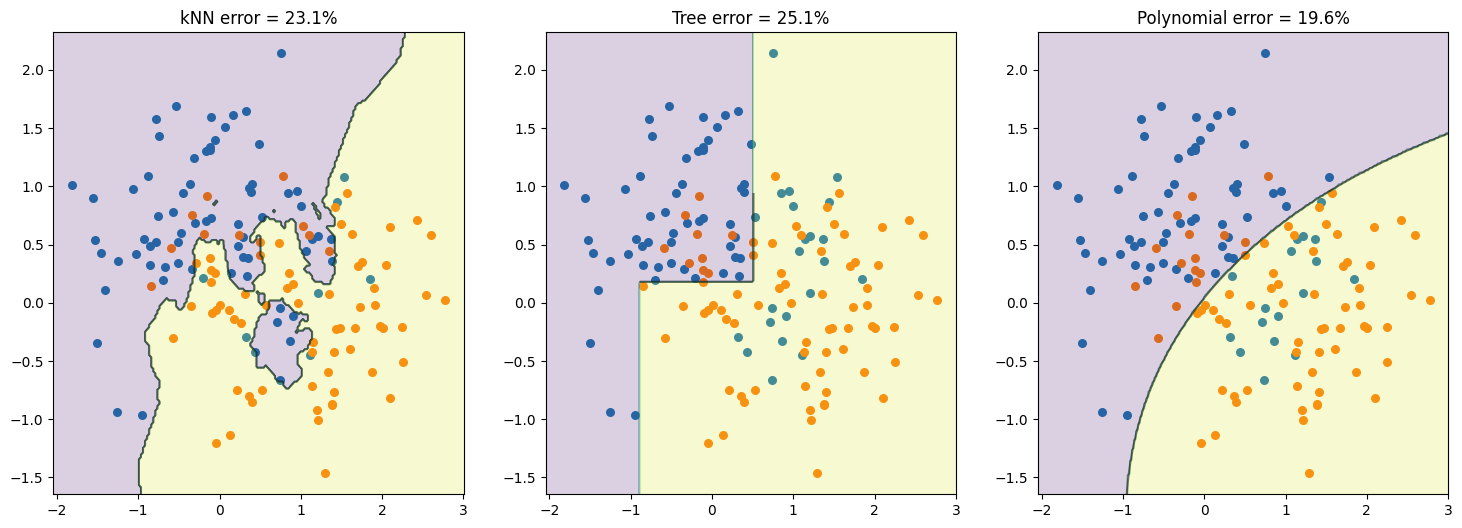

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Données d'apprentissage
X_train, y_train = make_moons(noise=noise, random_state=random_state, n_samples=150)
X_test, y_test = make_moons(noise=noise, random_state=random_state, n_samples=10000)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# k plus proches voisins
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

plt.sca(axs[0])
show_data_2D(X_train, y_train)
plot_decision_function(knn.predict_proba)
plt.title("kNN error = {:.1f}%".format(100*(1-knn.score(X_test, y_test))))

# Arbre de décision
tree = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split = 50)
tree.fit(X_train, y_train)

plt.sca(axs[1])
show_data_2D(X_train, y_train)
plot_decision_function(tree.predict_log_proba)
plt.title("Tree error = {:.1f}%".format(100*(1-tree.score(X_test, y_test))))

pda = Pipeline(steps=[("PolyAugment", PolynomialFeatures(degree=2,include_bias=True)),
     ("LinearDiscriminant", LinearDiscriminantAnalysis())]
     ).fit(X_train, y_train)

plt.sca(axs[2])
show_data_2D(X_train, y_train)
plot_decision_function(pda.predict_log_proba)
plt.title("Polynomial error = {:.1f}%".format(100*(1-pda.score(X_test, y_test))))


plt.show()


### Optimisation des hyperparamètres

Pour optimiser de manière systématique les hyperparamètres, une stratégie classique est d'effectuer une recherche exhaustive en calculant les performances sur une grille échantillonnant de manière indépendante chacun des paramètres. C'est ce qui est fait par la classe [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) qui permet de caler ("fit") un prédicteur optimisant la gamme d'hyperparamètres.


KNeighborsClassifier(n_neighbors=11)
Lowest kNN error = 11.3%
DecisionTreeClassifier(max_depth=2)
Lowest DTree error = 14.0%
Pipeline(steps=[('PolyAugment', PolynomialFeatures(degree=3)),
                ('LinearDiscriminant', LinearDiscriminantAnalysis())])
Lowest PDA error = 14.0%


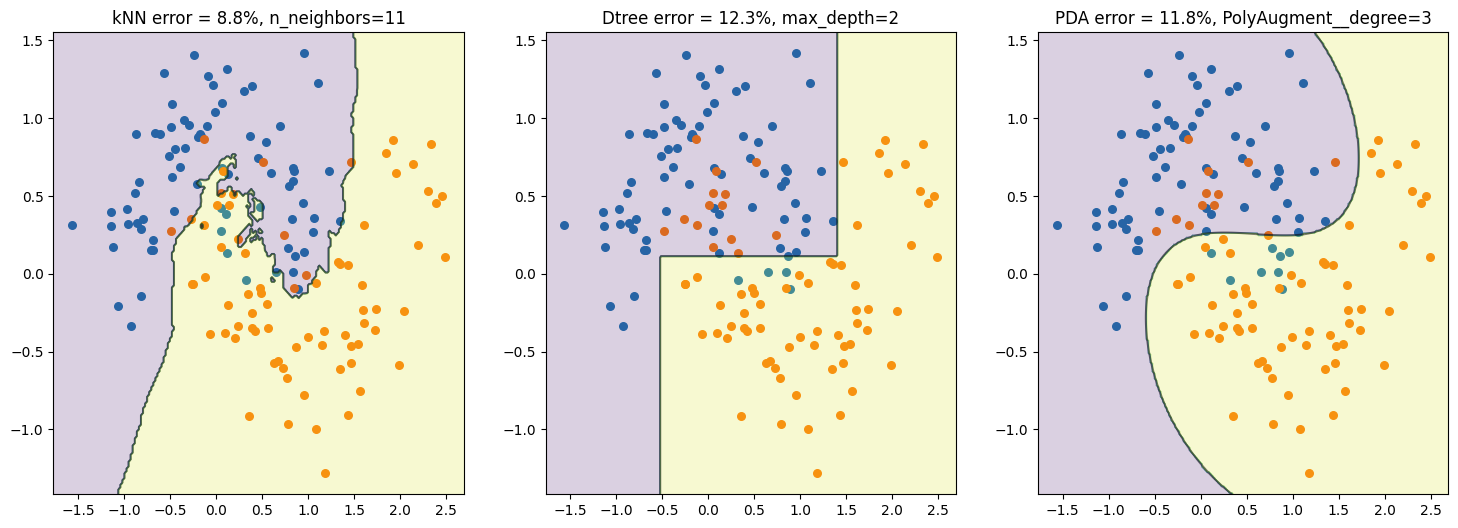

In [13]:
from sklearn.model_selection import GridSearchCV

random_state = datetime.now().microsecond
noise = 0.3
X_train, y_train = make_moons(noise=noise, random_state=random_state, n_samples=150)
X_test, y_test = make_moons(noise=noise, random_state=random_state, n_samples=1000)

# Plus proches voisins
knn = KNeighborsClassifier()
param_grid={'n_neighbors':[1, 3, 5, 7, 9, 11, 13]}

knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

print(knn_cv.best_estimator_)
print("Lowest kNN error = {:.1f}%".format(100*(1-knn_cv.best_score_)))

# Visualisation
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plt.sca(axs[0])
show_data_2D(X_train, y_train)
plot_decision_function(knn_cv.best_estimator_.predict_proba)
score = knn_cv.best_estimator_.score(X_test, y_test)
best_params = knn_cv.best_params_
plt.title("kNN error = {:.1f}%, {}={}".format(100*(1-score),list(best_params)[0],best_params[list(best_params)[0]]))

##############################################""
# Arbres de décision
tree = DecisionTreeClassifier()
param_grid={'max_depth':range(1,11), 'min_samples_split':[2,5,10,15,20]}

tree_cv = GridSearchCV(tree, param_grid, cv=10)
tree_cv.fit(X_train, y_train)

print(tree_cv.best_estimator_)
print("Lowest DTree error = {:.1f}%".format(100*(1-tree_cv.best_score_)))

# Discrimination polynomiale

pda = Pipeline(steps=[("PolyAugment", PolynomialFeatures(include_bias=True)),
     ("LinearDiscriminant", LinearDiscriminantAnalysis())]
     ).fit(X_train, y_train)

param_grid={'PolyAugment__degree':[1,2,3,4,5]}

pda_cv = GridSearchCV(pda, param_grid, cv=10)
pda_cv.fit(X_train, y_train)

print(pda_cv.best_estimator_)
print("Lowest PDA error = {:.1f}%".format(100*(1-pda_cv.best_score_)))

plt.sca(axs[1])
show_data_2D(X_train, y_train)
plot_decision_function(tree_cv.best_estimator_.predict_proba)
score = tree_cv.best_estimator_.score(X_test, y_test)
best_params = tree_cv.best_params_
plt.title("Dtree error = {:.1f}%, {}={}".format(100*(1-score),list(best_params)[0],best_params[list(best_params)[0]]))

plt.sca(axs[2])
show_data_2D(X_train, y_train)
plot_decision_function(pda_cv.best_estimator_.predict_proba)
score = pda_cv.best_estimator_.score(X_test, y_test)
best_params = pda_cv.best_params_
plt.title("PDA error = {:.1f}%, {}={}".format(100*(1-score),list(best_params)[0],best_params[list(best_params)[0]]))

##############################################""

plt.show()
